# MMC Laboratorium 6

Autor: Jakub Ostrzołek

## Zadanie 1 - model mikrokanoniczny

### Funkcje ładujące wyniki działania programu `ising`

In [17]:
import numpy as np

from __future__ import annotations
from dataclasses import dataclass
from typing import TextIO

BINARY = "./out/ising"


@dataclass
class ExperimentResultMicrocanonical:
    system_energy_mean: float
    ghost_energy_mean: float
    magnetization_mean: float
    temperature: float

    @classmethod
    def from_io(cls, output: TextIO) -> ExperimentResultMicrocanonical:
        lines = [line for line in output.readlines() if "=" in line]
        values = [line.split("=")[1].strip() for line in lines]
        return cls(*map(float, values))

### Funkcje uruchamiające program `ising`

Zmodyfikowałem program `ising` tak, żeby przyjmował swoje parametry poprzez argumenty wywołania linii poleceń.

In [18]:
from subprocess import run
from io import StringIO


def run_experiment(
    side: int | None = None,
    energy: int | None = None,
    temperature: float | None = None,
    steps: int | None = None,
) -> TextIO:
    cli_args_dict = {
        "--bok-mapy": side,
        "--energia": energy,
        "--temperatura": temperature,
        "--liczba-krokow": steps,
    }
    cli_args = [
        [key, str(value)] for key, value in cli_args_dict.items() if value is not None
    ]

    command = [BINARY, *(arg for arg_set in cli_args for arg in arg_set)]

    process = run(command, capture_output=True, encoding="UTF-8")
    process.check_returncode()

    return StringIO(process.stdout)


def run_experiment_microcanonical(
    side: int = 10,
    energy: int = -184,
    steps: int = 1000,
) -> ExperimentResultMicrocanonical:
    out_buffer = run_experiment(side=side, energy=energy, steps=steps)
    return ExperimentResultMicrocanonical.from_io(out_buffer)

### Wywołanie programu z domyślnymi parametrami

In [19]:
run_experiment_microcanonical()

ExperimentResultMicrocanonical(system_energy_mean=-184.28, ghost_energy_mean=0.28, magnetization_mean=0.95714, temperature=1.46686)

### Wywołanie programu dla zadanych w zadaniu parametrów

In [20]:
sides = [10, 20, 40]

energy_sets = [
    [*range(-184, -24 + 1, 8)],
    [*range(-768, -32 + 1, 32)],
    [*range(-3072, -128 + 1, 128)],
]

result_sets = [
    [run_experiment_microcanonical(side=side, energy=energy) for energy in energies]
    for energies, side in zip(energy_sets, sides)
]

### Wizualizacja wyników działania programu `ising`

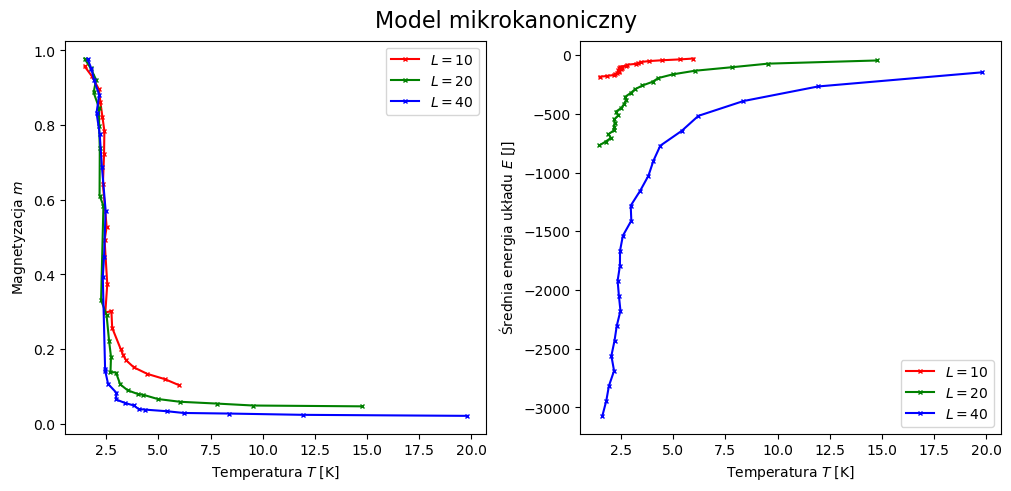

In [21]:
from matplotlib import pyplot as plt

colors = ["r", "g", "b"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.8), constrained_layout=True)
fig.suptitle("Model mikrokanoniczny", fontsize=16)

for results, side, color in zip(result_sets, sides, colors):
    temperatures = [result.temperature for result in results]
    magnetizations = [result.magnetization_mean for result in results]
    energies = [result.system_energy_mean for result in results]

    ax1.plot(
        temperatures, magnetizations, f"{color}x-", markersize=3, label=f"$L={side}$"
    )
    ax1.set_xlabel("Temperatura $T$ [K]")
    ax1.set_ylabel("Magnetyzacja $m$")
    ax1.legend()

    ax2.plot(temperatures, energies, f"{color}x-", markersize=3, label=f"$L={side}$")
    ax2.set_xlabel("Temperatura $T$ [K]")
    ax2.set_ylabel("Średnia energia układu $E$ [J]")
    ax2.legend()

plt.show()

Na lewym wykresie widać przemianę fazową kryształu, gdzie poniżej ok. $2.5 K$ atomy są chętne kierować się w tę samą stronę (magnetyzacja równa 1), a powyżej $2.5 K$ atomy ustawiają się w gruncie rzeczy losowo, przez co nie są spolaryzowane w jedną stronę (magnetyzacja równa 0).

Na prawym wykresie każda z linii ma podobny kształt, ale te odpowiadające bardziej licznym próbom są nieco rozciągnięte w dół.
Lewą i prawą granicę tych funkcji można obliczyć z równań:
* $\langle E(T=0) \rangle = -NJ\frac{j}{2} = -L^2 \frac{4}{2} = -2L^2$, gdzie:
  * $N = L^2$ - liczba atomów,
  * $J = 1$ - stała oddziaływania (może być różna, w implementacji równa 1),
  * $j = 4$ - liczba sąsiadów branych pod uwagę.

  Zależność wynika z sumy energi atomów w stanie początkowym.
* $\langle E(T\longrightarrow \infty ) \rangle \longrightarrow 0$ - zależność wynika z tego, że im wyższa jest temperatura tym spiny słabiej wiążą się z sąsiadami, a więc maleje szansa na wystąpienie identycznych spinów obok siebie. Zgodnie ze wzorem na energię w modelu Isinga $\langle E \rangle = -J\sum_{\langle ij \rangle} s_i s_j$, jeżeli żadne z sąsiadujących spinów nie będą zgodne, to $\langle E \rangle = 0$.

Widać, że oba równania są w przybliżeniu spełnione.

## Zadanie 2 - model kanoniczny

Zmodyfikowałem program `ising` tak, żeby przy podaniu parametru `--temperatura` można było przełączyć go w tryb pracowania zgodnie z modelem kanonicznym. Służy do tego osobna klasa `ModelIsingaKanoniczny`.

### Funkcje ładujące wyniki działania i uruchamiające program `ising`

In [22]:
@dataclass
class ExperimentResultCanonical:
    system_energy_mean: float
    magnetization_mean: float
    temperature: float

    @classmethod
    def from_io(cls, output: TextIO) -> ExperimentResultCanonical:
        lines = [line for line in output.readlines() if "=" in line]
        values = [line.split("=")[1].strip() for line in lines]
        return cls(*map(float, values))


def run_experiment_canonical(
    side: int = 10,
    temperature: float = 0,
    steps: int = 1000,
) -> ExperimentResultCanonical:
    out_buffer = run_experiment(side=side, temperature=temperature, steps=steps)
    return ExperimentResultCanonical.from_io(out_buffer)

### Wywołanie programu z domyślnymi parametrami

In [23]:
run_experiment_canonical()

ExperimentResultCanonical(system_energy_mean=-200.0, magnetization_mean=1.0, temperature=0.0)

### Wywołanie programu dla zadanych w zadaniu parametrów

In [24]:
sides = [10, 20, 40]

temperatures = np.linspace(1.5, 4, 40)

result_sets = [
    [
        run_experiment_canonical(side=side, temperature=temperature)
        for temperature in temperatures
    ]
    for side in sides
]

### Wizualizacja wyników działania programu `ising`

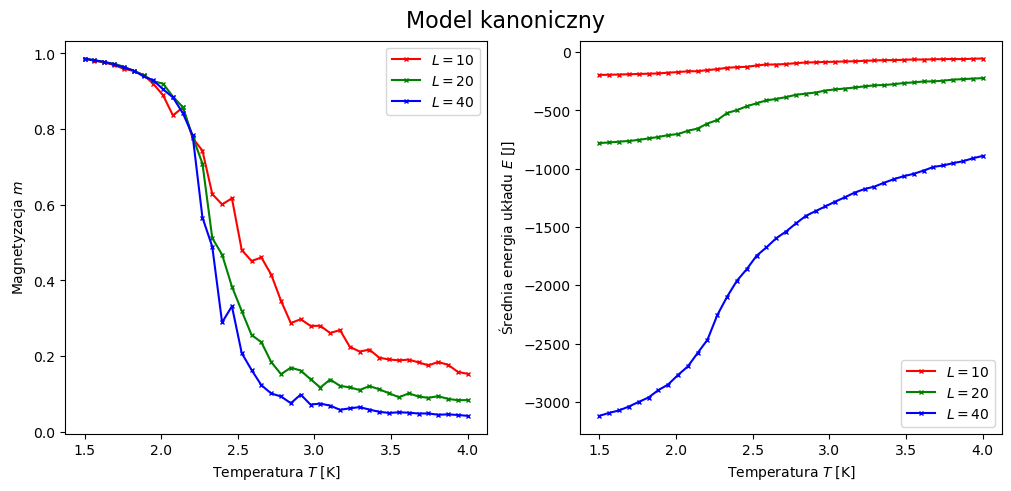

In [25]:
from matplotlib import pyplot as plt

colors = ["r", "g", "b"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.8), constrained_layout=True)
fig.suptitle("Model kanoniczny", fontsize=16)

for results, side, color in zip(result_sets, sides, colors):
    temperatures = [result.temperature for result in results]
    magnetizations = [result.magnetization_mean for result in results]
    energies = [result.system_energy_mean for result in results]

    ax1.plot(
        temperatures, magnetizations, f"{color}x-", markersize=3, label=f"$L={side}$"
    )
    ax1.set_xlabel("Temperatura $T$ [K]")
    ax1.set_ylabel("Magnetyzacja $m$")
    ax1.legend()

    ax2.plot(temperatures, energies, f"{color}x-", markersize=3, label=f"$L={side}$")
    ax2.set_xlabel("Temperatura $T$ [K]")
    ax2.set_ylabel("Średnia energia układu $E$ [J]")
    ax2.legend()

plt.show()

Wyniki wychodzą podobne jak w zadaniu 1, ale tym razem mamy szansę dokładnie sterować temperaturą, co pozwala na sporządzenie dokładniejszych wykresów.